In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_utils import *
from dataset import Dataset
from basicnet import Net
import matplotlib.pyplot as plt

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

params = {'benchmark': 'adult', 'maxlen': 0, 'batch_size': 500,
          'split': [0.7, 0.2, 0.1], 'seed': 2,
          'epochs': 100, 'lr': 0.001}
data = Dataset(params, 'train', device)

model = Net(data.nfeatures, [10,5])
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

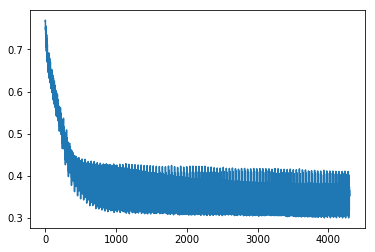

In [2]:
y_loss=[]
for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        optimizer.zero_grad()
        ŷ = model(x)
        loss = loss_fn(ŷ, y)
        y_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
plt.plot(y_loss)

In [14]:
from cache import Cache
cache = Cache(2) # we'll use only the hidden layers

for epoch in range(params['epochs']):
    for (x, y) in data:
        (x, y) = x.to(device), y.to(device)
        h2 = model.get_embedding(x, 1) 
        cache.store(h2, 1)

        h3 = model.get_embedding(x, 2) 
        cache.store(h3, 2)

In [17]:
from autoencoder import AutoEncoder
ae1 = AutoEncoder(model._l_dim[1], 2)
ae2 = AutoEncoder(model._l_dim[2], 2)

ae_loss1 = nn.MSELoss()
ae_loss2 = nn.MSELoss()
opt1 = optim.Adam(ae1.parameters(), lr=0.001)
opt2 = optim.Adam(ae2.parameters(), lr=0.001)

y1_loss=[]
y2_loss=[]

for epoch in range(5):#params['epochs']):
    for x1 in cache.embeddings[1]:
        opt1.zero_grad()
        x̃1 = ae1(x1)
        l1 = ae_loss1(x̃1, x1)
        l1.backward(retain_graph=True)
        opt1.step() 
        y1_loss.append(l1.item())
    
    for x2 in cache.embeddings[2]:
        opt2.zero_grad()
        x̃2 = ae2(x2)
        l2 = ae_loss2(x̃2, x2)
        l2.backward(retain_graph=True)
        opt2.step()
        y2_loss.append(l2.item())

0
1
2
3
4


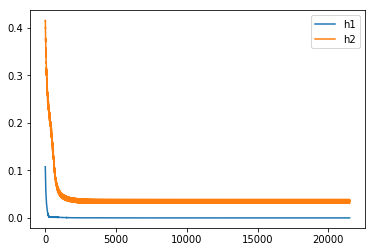

In [20]:
plt.plot(y1_loss)
plt.plot(y2_loss)
plt.legend(['h1', 'h2'])